In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

## LSun bedroom data

In [2]:
from fastai.vision import *
from fastai.vision.gan import *

### 数据获取

In [3]:
path = untar_data(URLs.LSUN_BEDROOMS)

In [4]:
path
path.ls()

PosixPath('/home/lyc/.fastai/data/bedroom')

[PosixPath('/home/lyc/.fastai/data/bedroom/7'),
 PosixPath('/home/lyc/.fastai/data/bedroom/f'),
 PosixPath('/home/lyc/.fastai/data/bedroom/5'),
 PosixPath('/home/lyc/.fastai/data/bedroom/3'),
 PosixPath('/home/lyc/.fastai/data/bedroom/6'),
 PosixPath('/home/lyc/.fastai/data/bedroom/8'),
 PosixPath('/home/lyc/.fastai/data/bedroom/d'),
 PosixPath('/home/lyc/.fastai/data/bedroom/1'),
 PosixPath('/home/lyc/.fastai/data/bedroom/b'),
 PosixPath('/home/lyc/.fastai/data/bedroom/c'),
 PosixPath('/home/lyc/.fastai/data/bedroom/9'),
 PosixPath('/home/lyc/.fastai/data/bedroom/models'),
 PosixPath('/home/lyc/.fastai/data/bedroom/a'),
 PosixPath('/home/lyc/.fastai/data/bedroom/e'),
 PosixPath('/home/lyc/.fastai/data/bedroom/0'),
 PosixPath('/home/lyc/.fastai/data/bedroom/4'),
 PosixPath('/home/lyc/.fastai/data/bedroom/2')]

### feature losses

In [5]:
def get_data(bs, size):
    """
    不分割训练集和验证集
    """
    return (GANItemList.from_folder(path, noise_sz=100)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

In [6]:
data = get_data(128, 32)

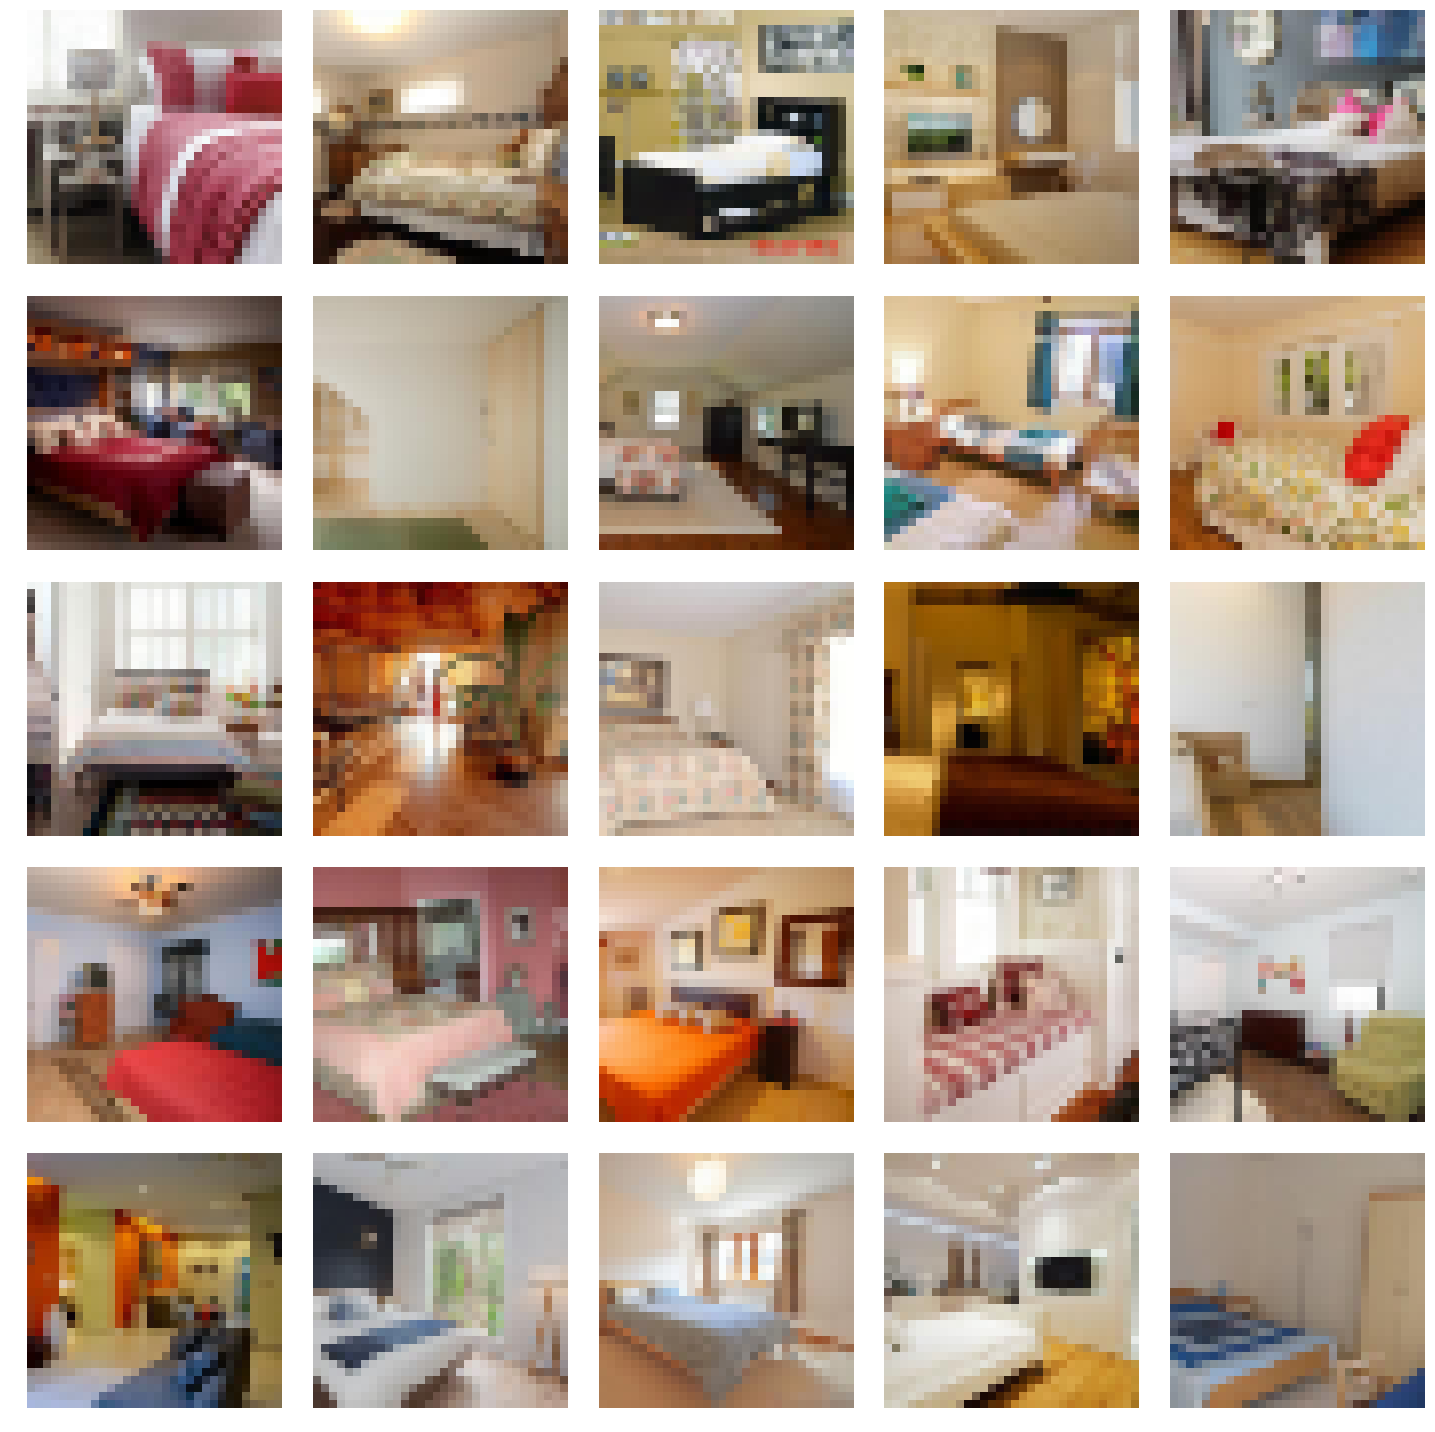

In [7]:
data.show_batch(rows=5)

GAN 表示 Generative Adversarial Nets 由 Ian Goodfellow 发明. 同时训练两个模型，一个生成器一个判别器. 生成器生成类似于真实数据的新数据，判别器分类新数据是否是真实的。生成器返回图片，判别器返回数值，(usually 0. for fake images and 1. for real ones).

- freeze生成器训练判别器的步骤:
    - 获取一个batch的真实图片
    - 生成一个batch的假图片
    - 判别器计算损失; 
    - 奖励真实图片，惩罚假图片
    - 更新判别器的权重
- Freeze 判别器训练生成器的步骤:
    - 生成一个batch的假图片
    - 判别器评价生成的图片
    - 奖励真实图片，惩罚假图片
    - 更新生成器的权重
- [Wassertein GAN](https://arxiv.org/pdf/1701.07875.pdf).

In [8]:
generator = basic_generator(in_size=32, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (in_size=32, n_channels=3, n_extra_layers=1)

In [9]:
generator

Sequential(
  (0): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=

In [10]:
critic

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=Fa

In [11]:
learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.001)

In [12]:
learn.model

GANModule(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,-0.021306,#na#,-0.022490,-0.020275,19:16


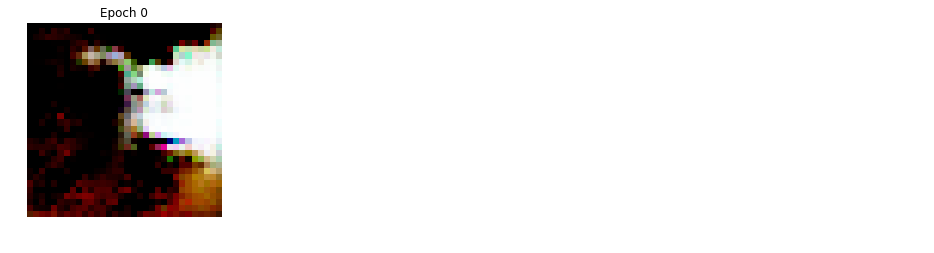

In [ ]:
learn.fit(30, 1e-3)

- 切换到生成器并生成预测结果

In [ ]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=8)